In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from bams.testsystems import *
from bams.sams_adapter import SAMSAdaptor

# Comparing SAMS and BAMS for independent state samples
This notebook compares the performance of SAMS and BAMS for the ideal case when one can sample exactly and independently from the state catogorical distribution. While this is unlikely to occur in practise, it is a necessary first step to validate the performance of the Bayesian scheme. In this setting, the Bayesians schemes are expected to dominate the SAMS schemes because the posterior density has been derived for this context.

The data from the online BAMS repeats will be loaded seperately as many repeats take a long time to compute. As SAMS is very quick to run, especially for this idea case, the convergence data will be computed in this notebook using the function below.

#### Function to compute the SAMs error when sampling from the multinomial distribution

In [2]:
def multinomial_sams_error(repeats, niterations, f_range, beta, nstates=2):
    """
    Function to compute the mean-squared error of the SAMS binary update scheme when drawing samples from
    the multinomial distribution. Over many repeats, target free energies will be drawn randomly and uniformly
    from a specified range and SAMS will adapt to those free energies. 
    
    Parameters
    ----------
    repeats: int
        The number of repeats with which to draw target free energies and run SAMS
    ninterations:
        The number of state samples generated and SAMS adaptive steps
    f_range: float
        The interval over which target free energies will be drawn
    beta: float
        The exponent for the SAMS burn-in stage
    nstates: int
        The number of states and target free energies.
    """
    binary_aggregate_msd = np.zeros((repeats,niterations))
    for r in range(repeats):
        f_true = np.random.uniform(low=-f_range/2.0, high=f_range/2.0, size=nstates )
        f_true -= f_true[0]
        sigmas = gen_sigmas(sigma1=1, f=f_true)

        generator = IndependentMultinomialSamper(free_energies=f_true)
        adaptor = SAMSAdaptor(nstates=nstates, beta=beta)

        for i in range(niterations):
            noisy = generator.sample()
            state = np.where(noisy != 0)[0][0]
            z = -adaptor.update(state=state, noisy_observation=noisy, histogram=generator.state_counter)
            generator.zetas = z
            binary_aggregate_msd[r,i] = np.mean((f_true - z)**2)
    return binary_aggregate_msd

## Free energies in the range of -200 to 200
### Prior standard deviation of 100
This example tests the performance of SAMS and BAMS when the free energy between 2 states can span a range of 400 thermal units of energy. The prior for the Bayesian scheme has standard deviation of 100, so it is narrower than the distribution used to generate the target free energies. All initial guesses for the free energy difference between the two states start at 0.

In [16]:
# Loading BAMS convergence data
## Update scheme = Thompson sampling
error_thompson = np.load('t_spread=200/error_thompson.npy')
mu_error_thompson = error_thompson.mean(axis=0)
std_error_thompson = error_thompson.std(axis=0) / float(np.sqrt(error_thompson.shape[0]))

# Update scheme = MAP estimate
error_map = np.load('t_spread=200/error_map.npy')
mu_error_map = error_map.mean(axis=0)
std_error_map = error_map.std(axis=0) / float(np.sqrt(error_map.shape[0]))

# Loading SAMS convergence data
## Two stage procedure with beta = 0.5
error_sams_beta05 = multinomial_sams_error(repeats=300, niterations=100, f_range=400.0, beta=0.5)
mu_error_sams_beta05 = error_sams_beta05.mean(axis=0)
std_error_sams_beta05 = error_sams_beta05.std(axis=0) / float(np.sqrt(error_sams_beta05.shape[0]))

# Loading SAMS convergence data
## Two stage procedure with beta = 0.1
error_sams_beta01 = multinomial_sams_error(repeats=300, niterations=100, f_range=400.0, beta=0.1)
mu_error_sams_beta01 = error_sams_beta01.mean(axis=0)
std_error_sams_beta01 = error_sams_beta01.std(axis=0) / float(np.sqrt(error_sams_beta01.shape[0]))

#### Plotting the means-squared error for each method as a function of iteration

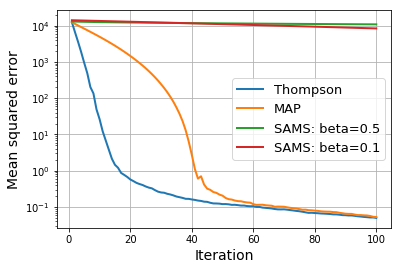

In [20]:
a = 0.5
t = np.arange(1, len(mu_error_map)+1)
# BAMS Thompson
plt.semilogy(t, mu_error_thompson, lw=2, label='Thompson')
#upper = mu_error_thompson + std_error_thompson
#lower = mu_error_thompson - std_error_thompson
#plt.fill_between(t, lower, upper, alpha=a)
# BAMS MAP
plt.semilogy(t, mu_error_map, lw=2, label='MAP')
#plt.fill_between(t, mu_error_map - std_error_map, mu_error_map + std_error_map, alpha=0.5 )
# SAMS beta=0.5
plt.semilogy(t, mu_error_sams_beta05, lw=2, label='SAMS: beta=0.5', color='C2')
#plt.semilogy(t, mu_error_sams_beta05 - std_error_sams_beta05/2.0, lw=1, color='C2', alpha=a)
#plt.semilogy(t, mu_error_sams_beta05 + std_error_sams_beta05/2.0, lw=1, color='C2', alpha=a)
# SAMS beta=0.1
plt.semilogy(t, mu_error_sams_beta01, lw=2, label='SAMS: beta=0.1', color='C3')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Mean squared error', fontsize=14)
plt.legend(fontsize=13)
plt.grid()
plt.show()

# Free energies in the range of -1 to 1
## Prior standard deviation = 1

In this example, the range of unknown free energy is much closer to the initial guess of 0. As above, the prior for the Bayesian scheme is slightly less broad than the true distribution from which the free energies are drawn.

In [5]:
# Loading BAMS convergence data
## Update scheme = Thompson sampling
error_thompson = np.load('t_spread=1_p_spread=1/error_thompson.npy')
mu_error_thompson = error_thompson.mean(axis=0)
std_error_thompson = error_thompson.std(axis=0) / np.sqrt(error_thompson.shape[0])

# Update scheme = MAP estimate
error_map = np.load('t_spread=1_p_spread=1/error_map.npy')
mu_error_map = error_map.mean(axis=0)
std_error_map = error_map.std(axis=0) / np.sqrt(len(mu_error_map))

# Loading SAMS convergence data
## Two stage procedure with beta = 0.5
error_sams_beta05 = multinomial_sams_error(repeats=300, niterations=100, f_range=2.0, beta=0.5)
mu_error_sams_beta05 = error_sams_beta05.mean(axis=0)
std_error_sams_beta05 = error_sams_beta05.std(axis=0) / np.sqrt(error_sams_beta05.shape[0])

# Loading SAMS convergence data
## Two stage procedure with beta = 0.1
error_sams_beta01 = multinomial_sams_error(repeats=300, niterations=100, f_range=2.0, beta=0.1)
mu_error_sams_beta01 = error_sams_beta01.mean(axis=0)
std_error_sams_beta01 = error_sams_beta01.std(axis=0) / np.sqrt(error_sams_beta01.shape[0])

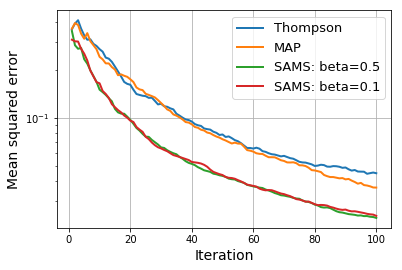

In [6]:
plt.clf()
t = np.arange(1, len(mu_error_map)+1)
# BAMS Thompson
plt.semilogy(t, mu_error_thompson, lw=2, label='Thompson')
# BAMS MAP
plt.semilogy(t, mu_error_map, lw=2, label='MAP')
# SAMS beta=0.5
plt.semilogy(t, mu_error_sams_beta05, lw=2, label='SAMS: beta=0.5')
# SAMS beta=0.1
plt.semilogy(t, mu_error_sams_beta01, lw=2, label='SAMS: beta=0.1')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Mean squared error', fontsize=14)
plt.legend(fontsize=13)
plt.grid()
plt.show()

# Free energies in the range of -1 to 1
## Prior standard deviation = 100

In this example, the prior distribution is much broader than the distribution used to draw the free energies from.

In [7]:
# Loading BAMS convergence data
## Update scheme = Thompson sampling
error_thompson = np.load('t_spread=1/error_thompson.npy')
mu_error_thompson = error_thompson.mean(axis=0)
std_error_thompson = error_thompson.std(axis=0) / np.sqrt(error_thompson.shape[0])

# Update scheme = MAP estimate
error_map = np.load('t_spread=1/error_map.npy')
mu_error_map = error_map.mean(axis=0)
std_error_map = error_map.std(axis=0) / np.sqrt(len(mu_error_map))

# Loading SAMS convergence data
## Two stage procedure with beta = 0.5
error_sams_beta05 = multinomial_sams_error(repeats=300, niterations=100, f_range=2.0, beta=0.5)
mu_error_sams_beta05 = error_sams_beta05.mean(axis=0)
std_error_sams_beta05 = error_sams_beta05.std(axis=0) / np.sqrt(error_sams_beta05.shape[0])

# Loading SAMS convergence data
## Two stage procedure with beta = 0.1
error_sams_beta01 = multinomial_sams_error(repeats=300, niterations=100, f_range=2.0, beta=0.1)
mu_error_sams_beta01 = error_sams_beta01.mean(axis=0)
std_error_sams_beta01 = error_sams_beta01.std(axis=0) / np.sqrt(error_sams_beta01.shape[0])

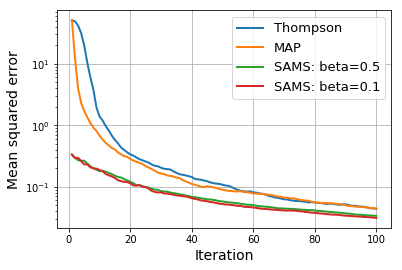

In [8]:
plt.clf()
t = np.arange(1, len(mu_error_map)+1)
# BAMS Thompson
plt.semilogy(t, mu_error_thompson, lw=2, label='Thompson')
# BAMS MAP
plt.semilogy(t, mu_error_map, lw=2, label='MAP')
# SAMS beta=0.5
plt.semilogy(t, mu_error_sams_beta05, lw=2, label='SAMS: beta=0.5')
# SAMS beta=0.1
plt.semilogy(t, mu_error_sams_beta01, lw=2, label='SAMS: beta=0.1')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Mean squared error', fontsize=14)
plt.legend(fontsize=13)
plt.grid()
plt.show()

# Correlated sampling
## Gaussian mixtures

In [26]:
# Loading BAMS convergence data
## Update scheme = Thompson sampling
error_thompson = np.load('bams_gaussian_thompson.npy')
mu_error_thompson = np.percentile(error_thompson, 50, axis=0)

# Update scheme = MAP estimate
error_map = np.load('bams_gaussian_map.npy')
mu_error_map= np.percentile(error_map, 50, axis=0)

std_error_map = error_map.std(axis=0) / np.sqrt(len(mu_error_map))

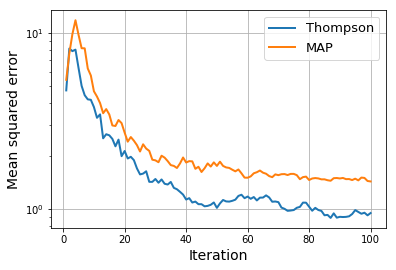

In [30]:
alpha = 0.3
# BAMS Thompson
error = np.load('bams_gaussian_thompson.npy')
mu = np.percentile(error, 50, axis=0)
t = np.arange(1, len(mu)+1)
upper = np.percentile(error, 97.5, axis=0)
lower = np.percentile(error, 2.5, axis=0)
plt.semilogy(t, mu, lw=2, label='Thompson')
#plt.fill_between(t, lower, upper, alpha=alpha)
# BAMS MAP
error = np.load('bams_gaussian_map.npy')
mu = np.percentile(error, 50, axis=0)
t = np.arange(1, len(mu)+1)
upper = np.percentile(error, 97.5, axis=0)
lower = np.percentile(error, 2.5, axis=0)
plt.semilogy(t, mu, lw=2, label='MAP')
#plt.fill_between(t, lower, upper, alpha=alpha)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Mean squared error', fontsize=14)
plt.legend(fontsize=13)
plt.grid()
plt.show()

In [7]:
error_thompson[1,:,:].shape

(100, 1)

In [24]:
mu_error_map.shape

(100, 1)